# !!!!!!! CLEAR OUTPUT BEFORE COMMIT !!!!!!
TODO:
- Fix scaling of SalePrice
  - Remove it prior to scaling
- Check for outliers and remove?
- Try different models
  - RandomForest - Done
  - XGBoost
  - LightGBM

In [1]:
import pandas as pd
import numpy as np
import os

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def one_hot_encode(df, col_name_list):
    #for col_name in col_name_list:
    #    df = pd.concat((df, pd.get_dummies(df[col_name], prefix=col_name)), axis='columns')
    df.drop(columns=col_name_list, inplace=True)
    return df

def a_f_ohe(df, column_name, one_hot_encode_list):
    if not one_hot_encode_list:
        one_hot_encode_list = []
    #df[column_name] = column_name + df[column_name].astype(str)
    if not column_name in one_hot_encode_list:
        one_hot_encode_list = one_hot_encode_list + [column_name]
    return one_hot_encode_list

def calculate_ages(df):
    df['SaleDate'] = df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str)
    df['SaleDate'] = pd.to_datetime(df['SaleDate'], format='%Y-%m')
    
    # YrSold
    df['SaleAge'] = (df['SaleDate'].dt.year + df['SaleDate'].dt.month / 12) - \
        (df['YrSold'].astype(float) + df['MoSold'].astype(float) / 12)
    del df['YrSold']
    
    # YearBuilt
    df['Age'] = df['SaleDate'].dt.year - df['YearBuilt']
    del df['YearBuilt']
    
    # YearRemodAdd
    df['RemodelAge'] = df['SaleDate'].dt.year - df['YearRemodAdd']
    del df['YearRemodAdd']
    
    # GarageYrBlt
    df['GarageAge'] = df['SaleDate'].dt.year - df['GarageYrBlt']
    del df['GarageYrBlt']
    
    # we are done using this field and it is not numeric, which causes issues with sklearn
    del df['SaleDate']
    return df

def impute_lot_frontage(df):
    avg_ratio = (df['LotFrontage'] / df['LotArea']).mean()
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotArea'] * avg_ratio)
    return df

def process_df(df, ohe_list):
    df['CentralAir'] = df['CentralAir'].map({'Y':1,'N':0}).astype(int)
    
    mask = df['MasVnrType'] == 'None'
    df.loc[mask, 'MasVnrType'] = np.NAN
    
    mask = df['MasVnrType'].isnull()
    df.loc[mask, 'MasVnrArea'] = 0.0
    df['MasVnrArea'].fillna(0.0, inplace=True)

    mask = df['GarageYrBlt'].isnull()
    df.loc[mask, 'GarageYrBlt'] = df.loc[mask, 'YearBuilt']
    
    df = calculate_ages(df)
    df = impute_lot_frontage(df)
    df = one_hot_encode(df, ohe_list)
    if 'SalePrice' in df.columns.values:
        df['SalePrice'] = np.log(df['SalePrice'])
    return df

In [3]:
df = pd.read_csv(os.path.join('data','train.csv'))

In [4]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


How many records are we dealing with?

In [5]:
len(df.index)

1460

Because of the small size of the training and testing datasets we don't need to worry about converting data types to smaller sizes to conserve space.

What data types are we dealing with?

In [6]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


Let's take a look at the different features and get some simple summary statistics

In [7]:
df['1stFlrSF'].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

In [8]:
df['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

Which fields have null values?

In [9]:
df_nulls = df.copy().isnull().sum()
df_nulls = df_nulls.to_frame().rename(columns={0:'num_nulls'})
df_nulls['total_records'] = len(df.index)
df_nulls['pct_null'] = df_nulls['num_nulls'] / df_nulls['total_records'] * 100
df_nulls[df_nulls['num_nulls'] > 0].sort_values(by='pct_null', ascending=False)

,num_nulls,total_records,pct_null
PoolQC,1453,1460,99.520548
MiscFeature,1406,1460,96.301370
Alley,1369,1460,93.767123
Fence,1179,1460,80.753425
FireplaceQu,690,1460,47.260274
LotFrontage,259,1460,17.739726
GarageType,81,1460,5.547945
GarageYrBlt,81,1460,5.547945
GarageFinish,81,1460,5.547945
GarageQual,81,1460,5.547945


Wow, the PoolQC (Pool Quality) is almost always empty. Is this because:
- Most of the houses have no pools?
- How many houses have pools but no quality value?

In [10]:
df.loc[df['PoolArea'] > 0, ['PoolQC','PoolArea']]

,PoolQC,PoolArea
197,Ex,512
810,Fa,648
1170,Gd,576
1182,Ex,555
1298,Gd,480
1386,Fa,519
1423,Gd,738


There are no pools without a quality rating.

In [11]:
df.loc[~df['PoolQC'].isnull(), ['PoolQC','PoolArea']]

,PoolQC,PoolArea
197,Ex,512
810,Fa,648
1170,Gd,576
1182,Ex,555
1298,Gd,480
1386,Fa,519
1423,Gd,738


This shows us that only 7 houses had a pool and no pool quality records exist where there is no pool (pool area = 0)

Pools normally represent a small amount of houses so it's important to keep this around rather than attempting to just drop it since there are so few records.

To handle these we can One Hot Encode (pd.get_dummies) for the pool quality values. Any house without a pool will have 0 for all the quality measurements to work around the null values in the pool quality feature.

If we're doing something similar to the PoolQC we should explicitly show it like we did with PoolQC

In [12]:
ohe_list = [] #['PoolQC','Alley','Fence','MiscFeature']

**MSSubClass:** Identifies the type of dwelling involved in the sale.

In [13]:
# Prefix the categories so they make a bit more sense when we OHE them.
# Initially it's imported as a number so we'll force it to be a string
ohe_list = a_f_ohe(df, 'MSSubClass', ohe_list)

**MSZoning:** Identifies the general zoning classification of the sale.

In [14]:
ohe_list = a_f_ohe(df, 'MSZoning', ohe_list)

**LotFrontage:** Linear feet of street connected to property

Nothing to do here. This is a simple number. Perhaps scale?

**Street:** Type of road access to property

In [15]:
ohe_list = a_f_ohe(df, 'Street', ohe_list)

**Alley:** Type of alley access to property

In [16]:
ohe_list = a_f_ohe(df, 'Alley', ohe_list)

**LotShape:** General shape of property

In [17]:
ohe_list = a_f_ohe(df, 'LotShape', ohe_list)

**LandContour:** Flatness of the property

In [18]:
ohe_list = a_f_ohe(df, 'LandContour', ohe_list)

**Utilities:** Type of utilities available

In [19]:
ohe_list = a_f_ohe(df, 'Utilities', ohe_list)

**LotConfig:** Lot configuration

In [20]:
ohe_list = a_f_ohe(df, 'LotConfig', ohe_list)

**LandSlope:** Slope of property

In [21]:
ohe_list = a_f_ohe(df, 'LandSlope', ohe_list)

**Neighborhood:** Physical locations within Ames city limits

In [22]:
ohe_list = a_f_ohe(df, 'Neighborhood', ohe_list)

**Condition1:** Proximity to various conditions

Are these mutually exclusive values? They appear so.

In [23]:
df['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [24]:
ohe_list = a_f_ohe(df, 'Condition1', ohe_list)

**Condition2:** Proximity to various conditions (if more than one is present)

In [25]:
df['Condition2'].value_counts()

Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [26]:
ohe_list = a_f_ohe(df, 'Condition2', ohe_list)

**BldgType:** Type of dwelling

In [27]:
ohe_list = a_f_ohe(df, 'BldgType', ohe_list)

**HouseStyle:** Style of dwelling

In [28]:
ohe_list = a_f_ohe(df, 'HouseStyle', ohe_list)

**OverallQual:** Rates the overall material and finish of the house

Rating between 1 and 10 (Very Poor and Very Excellent) - Since this is numeric and has a natural relationship we'll leave alone.

**OverallCond:** Rates the overall condition of the house

Rating between 1 and 10 (Very Poor and Very Excellent) - Since this is numeric and has a natural relationship we'll leave alone.

**YearBuilt:** Original construction date

Convert this to be the ages in full years.

This is done within the calculate_ages to apply it to the train and test sets the same way.

**YearRemodAdd:** Remodel date (same as construction date if no remodeling or additions)

This is the same process as the YearBuilt

**RoofStyle:** Type of roof

In [29]:
ohe_list = a_f_ohe(df, 'RoofStyle', ohe_list)

**RoofMatl:** Roof material

In [30]:
ohe_list = a_f_ohe(df, 'RoofMatl', ohe_list)

**Exterior1st:** Exterior covering on house

In [31]:
ohe_list = a_f_ohe(df, 'Exterior1st', ohe_list)

**Exterior2nd:** Exterior covering on house (if more than one material)

In [32]:
ohe_list = a_f_ohe(df, 'Exterior2nd', ohe_list)

**MasVnrType:** Masonry veneer type

Convert None values to NaN, OHE the rest

In [33]:
mask = df['MasVnrType'] == 'None'
df.loc[mask, 'MasVnrType'] = np.NAN
ohe_list = a_f_ohe(df, 'MasVnrType', ohe_list)

**MasVnrArea:** Masonry veneer area in square feet

When MasVnrType is NaN, there a few (5) rows where the area is greater than zero. We are going to assume the area is supposed to be zero when there is no masonry veneer.

In [34]:
mask = df['MasVnrType'].isnull()
df[mask]['MasVnrArea'].value_counts()

0.0      859
1.0        2
312.0      1
344.0      1
288.0      1
Name: MasVnrArea, dtype: int64

In [35]:
df.loc[mask, 'MasVnrArea'] = 0.0
df['MasVnrArea'].fillna(0.0, inplace=True)

**ExterQual:** Evaluates the quality of the material on the exterior

In [36]:
ohe_list = a_f_ohe(df, 'ExterQual', ohe_list)

**ExterQual:** Evaluates the quality of the material on the exterior

In [37]:
ohe_list = a_f_ohe(df, 'ExterQual', ohe_list)

**ExterCond:** Evaluates the present condition of the material on the exterior

In [38]:
ohe_list = a_f_ohe(df, 'ExterCond', ohe_list)

**Foundation:** Type of foundation

In [39]:
ohe_list = a_f_ohe(df, 'Foundation', ohe_list)

**BsmtQual:** Evaluates the height of the basement

In [40]:
ohe_list = a_f_ohe(df, 'BsmtQual', ohe_list)

**BsmtCond:** Evaluates the general condition of the basement

In [41]:
ohe_list = a_f_ohe(df, 'BsmtCond', ohe_list)

**BsmtExposure:** Refers to walkout or garden level walls

In [42]:
ohe_list = a_f_ohe(df, 'BsmtExposure', ohe_list)

**BsmtFinType1:** Rating of basement finished area

In [43]:
ohe_list = a_f_ohe(df, 'BsmtFinType1', ohe_list)

**BsmtFinSF1:** Type 1 finished square feet
Numeric field. Perhaps Scale?

**BsmtFinType2:** Rating of basement finished area (if multiple types)

In [44]:
ohe_list = a_f_ohe(df, 'BsmtFinType2', ohe_list)

**BsmtFinSF2:** Type 2 finished square feet

Number - Scale?

**BsmtUnfSF:** Unfinished square feet of basement area

Number - scale?

**TotalBsmtSF:** Total square feet of basement area

Number - Scale?

**Heating:** Type of heating

In [45]:
ohe_list = a_f_ohe(df, 'Heating', ohe_list)

**HeatingQC:** Heating quality and condition

In [46]:
ohe_list = a_f_ohe(df, 'HeatingQC', ohe_list)

**CentralAir:** Central air conditioning

Boolean. Convery Y/N to 1/0

In [47]:
df['CentralAir'] = df['CentralAir'].map({'Y':1,'N':0}).astype(int)

**Electrical:** Electrical system

In [48]:
ohe_list = a_f_ohe(df, 'Electrical', ohe_list)

**1stFlrSF:** First Floor square feet

**2ndFlrSF:** Second floor square feet
 
**LowQualFinSF:** Low quality finished square feet (all floors)
 
**GrLivArea:** Above grade (ground) living area square feet
 
**BsmtFullBath:** Basement full bathrooms
 
**BsmtHalfBath:** Basement half bathrooms
 
**FullBath:** Full bathrooms above grade
 
**HalfBath:** Half baths above grade
 
**Bedroom:** Bedrooms above grade (does NOT include basement bedrooms)
 
**Kitchen:** Kitchens above grade

All numerical - not much to do here. Probably scale?

**KitchenQual:** Kitchen quality

In [49]:
ohe_list = a_f_ohe(df, 'KitchenQual', ohe_list)

**TotRmsAbvGrd:** Total rooms above grade (does not include bathrooms)

Number - not much to do here. Scale?

**Functional:** Home functionality (Assume typical unless deductions are warranted)

In [50]:
ohe_list = a_f_ohe(df, 'Functional', ohe_list)

**Fireplaces:** Number of fireplaces

Number, not much to do. Scale?

**FireplaceQu:** Fireplace quality

In [51]:
ohe_list = a_f_ohe(df, 'FireplaceQu', ohe_list)

**GarageType:** Garage location

In [52]:
ohe_list = a_f_ohe(df, 'GarageType', ohe_list)

**GarageYrBlt**: Year garage was built

Year - Convert to Age in years.

This is done within the calculate_ages function to apply to the train and test data sets the same way

In [53]:
mask = df['GarageYrBlt'].isnull()
df.loc[mask, 'GarageYrBlt'] = df.loc[mask, 'YearBuilt'] 

**GarageFinish:** Interior finish of the garage

In [54]:
ohe_list = a_f_ohe(df, 'GarageFinish', ohe_list)

**GarageCars:** Size of garage in car capacity
 
**GarageArea:** Size of garage in square feet

Numeric fields - scale?

**GarageQual:** Garage quality

In [55]:
ohe_list = a_f_ohe(df, 'GarageQual', ohe_list)

**GarageCond:** Garage condition

In [56]:
ohe_list = a_f_ohe(df, 'GarageCond', ohe_list)

**PavedDrive:** Paved driveway

In [57]:
ohe_list = a_f_ohe(df, 'PavedDrive', ohe_list)

**WoodDeckSF:** Wood deck area in square feet
 
**OpenPorchSF:** Open porch area in square feet
 
**EnclosedPorch:** Enclosed porch area in square feet
 
**3SsnPorch:** Three season porch area in square feet
 
**ScreenPorch:** Screen porch area in square feet
 
**PoolArea:** Pool area in square feet

Numeric, nothing to do.

**PoolQC:** Pool quality

In [58]:
ohe_list = a_f_ohe(df, 'PoolQC', ohe_list)

**Fence:** Fence quality

In [59]:
ohe_list = a_f_ohe(df, 'Fence', ohe_list)

**MiscFeature:** Miscellaneous feature not covered in other categories

In [60]:
ohe_list = a_f_ohe(df, 'MiscFeature', ohe_list)

**MiscVal:** $Value of miscellaneous feature

Numeric - Nothing to do

**YrSold:** Year Sold (YYYY)

This is done within the calculate_ages function to apply to the train and test datasets the same way.

**MoSold:** Month Sold (MM)

In [61]:
ohe_list = a_f_ohe(df, 'MoSold', ohe_list)

**SaleType:** Type of sale

In [62]:
ohe_list = a_f_ohe(df, 'SaleType', ohe_list)

**SaleCondition:** Condition of sale

In [63]:
ohe_list = a_f_ohe(df, 'SaleCondition', ohe_list)

### Transform / Prepare the DataFrame

In [64]:
df = calculate_ages(df)
df = one_hot_encode(df, ohe_list)

How many columns do we have?

In [65]:
len(df.columns)

37

Will this be too many columns or will our model function well enough as is? We might need to come back and re-evaulate all of the features within our dataset. Perhaps we might need to perform some Principal Component Analysis (PCA) to reduce our feature space.

## Scale the data
Since all of our data elements are now processed we need to scale our data so that every feature is on the same scale and we don't have certain features overly affecting the model.

StandardScaler requires data to not contain any NaN values. Let's take a look to see which columns have NaN values and determine how to handle them.

In [66]:
df.count()[df.count() != len(df.index)]

LotFrontage    1201
dtype: int64

If we drop the NaN values from the dataset which we'd lose 17.74% of our data which is too much and the fact that we have a smaller dataset.

In [67]:
df['LotFrontage'].agg([min, max])

min     21.0
max    313.0
Name: LotFrontage, dtype: float64

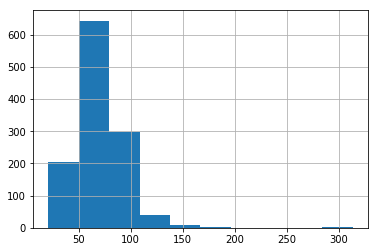

In [68]:
df['LotFrontage'].hist(bins=10)

Based on this histogram we can see there's a few outlier values which would skew the mean so using the mean might not be the best choice in this case.

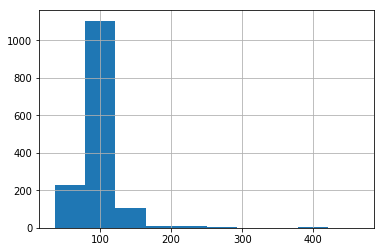

In [69]:
la = df['LotArea'] ** 0.5
la.hist(bins=10)

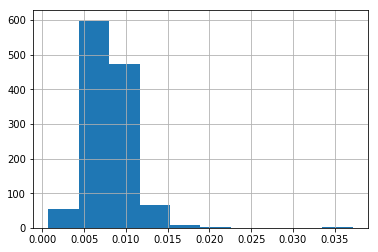

In [70]:
x = df['LotFrontage'] / df['LotArea']
x.hist()

We still have large outliers that would affect the average. What we'll do is just take the mean of the ratios under 0.015 and then multiply the lot area by this value to get the missing lot frontage.


But what is the median which isn't as adversely affected by the outliers?

In [71]:
df['LotFrontage'].median()

69.0

Let's take a quick and dirty look at the amount of LotFrontage if we use the ratio method.

In [72]:
df_copy = df.loc[df['LotFrontage'].isnull(), 'LotArea'].copy().to_frame()
df_copy['LotFrontage'] = 0.007 * df['LotArea']
df_copy

,LotArea,LotFrontage
7,10382,72.674
12,12968,90.776
14,10920,76.440
16,11241,78.687
24,8246,57.722
31,8544,59.808
42,9180,64.260
43,9200,64.400
50,13869,97.083
64,9375,65.625


As we can see there are a lot of larger lots which might skew the data if we used the median method.

In [73]:
df = impute_lot_frontage(df)
df.head(n=20)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,SaleAge,Age,RemodelAge,GarageAge
0,1,65.000000,8450,7,5,196.0,706,0,150,856,1,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,208500,0.0,5,5,5.0
1,2,80.000000,9600,6,8,0.0,978,0,284,1262,1,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,181500,0.0,31,31,31.0
2,3,68.000000,11250,7,5,162.0,486,0,434,920,1,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,223500,0.0,7,6,7.0
3,4,60.000000,9550,7,5,0.0,216,0,540,756,1,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,140000,0.0,91,36,8.0
4,5,84.000000,14260,8,5,350.0,655,0,490,1145,1,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,250000,0.0,8,8,8.0
5,6,85.000000,14115,5,5,0.0,732,0,64,796,1,796,566,0,1362,1,0,1,1,1,1,5,0,2,480,40,30,0,320,0,0,700,143000,0.0,16,14,16.0
6,7,75.000000,10084,8,5,186.0,1369,0,317,1686,1,1694,0,0,1694,1,0,2,0,3,1,7,1,2,636,255,57,0,0,0,0,0,307000,0.0,3,2,3.0
7,8,82.035516,10382,7,6,240.0,859,32,216,1107,1,1107,983,0,2090,1,0,2,1,3,1,7,2,2,484,235,204,228,0,0,0,350,200000,0.0,36,36,36.0
8,9,51.000000,6120,7,5,0.0,0,0,952,952,1,1022,752,0,1774,0,0,2,0,2,2,8,2,2,468,90,0,205,0,0,0,0,129900,0.0,77,58,77.0
9,10,50.000000,7420,5,6,0.0,851,0,140,991,1,1077,0,0,1077,1,0,1,0,2,2,5,2,1,205,0,4,0,0,0,0,0,118000,0.0,69,58,69.0


In [74]:
# Sale Price
from scipy.stats import boxcox

xt, maxlog = boxcox(df['SalePrice'])
print("lambda = {:g}".format(maxlog))

lambda = -0.076924


The Box-Cox test quickly and easily tells us if  we need to perform a transform on our data or not by telling us a lambda value:
* -1. is a reciprocal
* -.5 is a recriprocal square root
* 0.0 is a log transformation
* .5 is a square toot transform and
* 1.0 is no transform.

Since ours closest to 0 we need to perform a log transform on the sale price.

In [75]:
df['SalePrice'] = np.log(df['SalePrice'])

In [76]:
# Use a standard scaler to remove the mean and 
# make the standard deviation 1 for all of our features
# It will give us a range between 0 and 1
from sklearn.preprocessing import StandardScaler

# Using the defaults:
# - copy = True - Inplace / False doesn't always work
# - with_mean = True - May cause problems with a sparse matrix. We're going to try it as is and see how it fares
# - - Sparse matrix is a matrix where most feature values are 0
# - - - In our case we one hot encoded a lot of columns so we have a lot of 0 values
# - with_std = True - Scale with a single standard deviation
scaler = StandardScaler()
train_df = pd.read_csv(os.path.join('data','train.csv'))
test_df = pd.read_csv(os.path.join('data','test.csv'))
train_df = process_df(train_df, ohe_list)
test_df = process_df(test_df, ohe_list)

In [77]:
train_df.shape

(1460, 37)

In [78]:
test_df.shape

(1459, 36)

Initially the shape of the training and test sets do not align because of the One Hot Encoding might not have the same combinations.

In [79]:
cols_train_not_test = [c for c in train_df.columns if c not in test_df.columns and c != 'SalePrice']
cols_train_not_test

[]

In [80]:
cols_test_not_train = [c for c in test_df.columns if c not in train_df.columns]
cols_test_not_train

[]

Problem identified! We'll need to make sure the training and testing data sets have the same features.

In [81]:
for c in cols_train_not_test:
    test_df[c] = 0
    
for c in cols_test_not_train:
    train_df[c] = 0

In [82]:
test_df.shape

(1459, 36)

In [83]:
train_df.shape

(1460, 37)

In [84]:
# Which test data columns have NaNs?
null_columns = [col for col in test_df.columns if sum(test_df[col].isnull())]
null_columns

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea']

In [85]:
# Set these each to 0 because they don't have the features described
for c in null_columns:
    test_df[c] = test_df[c].fillna(0)

<font color='red'>GOTCHA: We ran into the issue of absurd home prices (negative and positive * e^18) because we initially removed the sale price from the dataframe prior to scaling. This is why scaling ALL of your data point the same is very important. Refer to submissions/LinearRegression_submission_1.csv for the actual values.</font>

In [86]:
# Remove SalePrice from dataframe before fit
# fit the remaining features
# scale x_train and x_test (transform)
# set y_train = SalePrice column

y_train = train_df['SalePrice'].copy()
train_df2 = train_df.drop('SalePrice', axis=1)


X_train = train_df2
X_test = test_df

#scaler.fit(train_df2)
#X_train = scaler.transform(train_df2)
#X_test = scaler.transform(test_df)


# Machine Learning Models!
a.k.a. the fun 20% rather than the annoying 80%.

Final Submission:
CSV File in the form of:
*ID, Predicted Sale Price*

Since we're predicting the home price and it's a continuous value Linear Regression model might be a good place to start.


In [87]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [88]:
predicted_prices = lr.predict(X_test)

In [89]:
# Revert log of predicted prices to determine 
# estimated sale price
predicted_prices = np.exp(predicted_prices)

In [90]:
max(predicted_prices)

1143748.7720284488

(array([752., 562., 121.,  21.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([  53015.99463138,  162089.27237109,  271162.5501108 ,
         380235.8278505 ,  489309.10559021,  598382.38332992,
         707455.66106962,  816528.93880933,  925602.21654904,
        1034675.49428874, 1143748.77202845]),
 <a list of 10 Patch objects>)

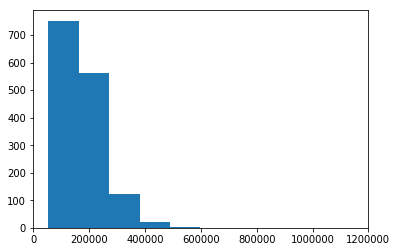

In [91]:
plt.hist(predicted_prices)

In [92]:
from sklearn.ensemble import RandomForestRegressor

rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
predicted_prices = rfg.predict(X_test)
predicted_prices = np.exp(predicted_prices)

/Users/marktrovinger/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(array([ 99., 562., 397., 193.,  93.,  54.,  33.,  10.,  10.,   8.]),
 array([ 48845.58315262,  98253.76089406, 147661.9386355 , 197070.11637694,
        246478.29411837, 295886.47185981, 345294.64960125, 394702.82734269,
        444111.00508413, 493519.18282557, 542927.36056701]),
 <a list of 10 Patch objects>)

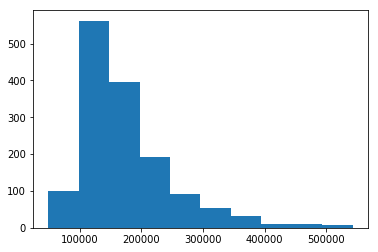

In [93]:
plt.hist(predicted_prices)

In [95]:
submission_df = pd.DataFrame({'Id':test_df['Id'], 'SalePrice':predicted_prices})
submission_df.to_csv(os.path.join('submissions', 'submission.csv'), index=False)

In [98]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rfg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.4s
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.4s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.4s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   6.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  20.8s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  21.3s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   3.8s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=   6.7s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   5.7s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   5.6s
[CV] n_estimators=1

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   2.2s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   2.1s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   2.7s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   4.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800,

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   2.9s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.5s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.5s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.5s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.0min


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  11.6s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  11.6s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  25.0s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  11.3s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=  11.4s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   4.5s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   4.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=  15.6s
[CV] n_estima

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   6.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.4s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   1.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   2.4s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   2.3s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   1.3s
[CV] n_estimators=1600, mi

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   2.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   2.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  14.1s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  14.2s
[CV] n_estimators=2000

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [99]:
best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [100]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [101]:
best_rf.predict(X_test)

array([11.74548592, 11.90863851, 12.14729324, ..., 12.05920589,
       11.65827849, 12.39359891])

In [103]:
predicted_prices = best_rf.predict(X_test)
predicted_prices = np.exp(predicted_prices)

In [104]:
submission_df = pd.DataFrame({'Id':test_df['Id'], 'SalePrice':predicted_prices})
submission_df.to_csv(os.path.join('submissions', 'submission.csv'), index=False)

In [106]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train)
dtest = xgb.DMatrix(X_test)
#xgb_model = xgb.XGBRegressor(silent=False,
                            )